In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import seaborn as sns
import functools
import itertools
import shapely
import datetime
import os
import copy
from pysal.lib import weights
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler

In [ ]:
##  coordinates
grids_coords = gpd.read_file(f'/content/drive/reference_grids.shp')

grids_coords['lon'] = grids_coords['geometry'].centroid.x
grids_coords['lat'] = grids_coords['geometry'].centroid.y
grids_coords['lon'] = grids_coords['lon'].apply(lambda x: round(x, 6))
grids_coords['lat'] = grids_coords['lat'].apply(lambda x: round(x, 6))

In [ ]:
###  call new brunswick air quality monitoring station data
nb_stations = pd.read_excel(f"./src/NB_Air_Quality_stations_metadata.xlsx")

# exclude stations that are not included or inactive
nb_stations = nb_stations[(nb_stations['city'].isin(['Saint John','Colson Cove'])) & (nb_stations['measurements'].isin(["SO2","TRS"]))]
nb_stations = nb_stations[~((nb_stations['station_name'] == "Forest Hills") & (nb_stations['owner'] == "Government of New Brunswick"))] 
nb_stations = nb_stations[nb_stations['station_name'] != "Musquash"]
nb_stations = nb_stations[nb_stations['station_name'] != "Milford"]
nb_stations = nb_stations[nb_stations['station_name'] != "Saint John Street"]

# projection
nb_stations['geometry'] = list(zip(nb_stations['longitude'], nb_stations['latitude']))
nb_stations['geometry'] = nb_stations['geometry'].apply(shapely.Point)
nb_stations = gpd.GeoDataFrame(nb_stations, geometry='geometry', crs = 'epsg:4326')

##  get grids with stations : for training
grid_stations = gpd.tools.sjoin(nb_stations, grids_coords, predicate="within", how='left')

In [ ]:
##  load outcome data
nb_records_path = f"./src/SJ FEM Station Data/"
nb_so2_files = [x for x in os.listdir(nb_records_path) if "NB FEM SO2" in x]

nb_so2_records = []

for s in range(len(nb_so2_files)):
    nb_station_records = pd.read_excel(nb_records_path + nb_so2_files[s])
    nb_station_records = nb_station_records.iloc[0:-1,:]

    nb_map_stations = list(nb_station_records.columns)[1:]
    nb_map_stations = [x for x in nb_map_stations if x != "Colson Cove - Musquash"]
    nb_map_stations = [x.replace("–", "-").replace(" - IOL", "") for x in nb_map_stations]

    nb_so2_records.append(nb_station_records)

##  combine & preprocess
nb_so2_records = pd.concat(nb_so2_records)

nb_so2_records = nb_so2_records.drop(["Colson Cove - Musquash"], axis=1)
nb_so2_records.columns = ["Result_Date"] + nb_map_stations

nb_so2_records = pd.melt(nb_so2_records, id_vars=["Result_Date"])
nb_so2_records.columns = ['time','station_name','so2']

nb_so2_records['station_name'] = nb_so2_records['station_name'].apply(lambda x: x.replace("Saint John - ", "").replace("Colson Cove - ", ""))
nb_so2_records['day_time'] = nb_so2_records['time'].apply(lambda x: x.date())
nb_so2_records = nb_so2_records.sort_values(by=['station_name','time']).reset_index(drop=True)

In [ ]:
##  create and obtain lags (day lag 1 = 24 hr; lag 2 = 48 hr; lag 3 = 72 hr)
for lag in range(24+48):
    nb_so2_records["so2_1hr_lag_" + str(lag+1)] = nb_so2_records.groupby(["station_name"])["so2"].shift(lag)

nb_so2_records['so2_4hr_lag_mean'] = nb_so2_records[["so2_1hr_lag_" + str(x) for x in range(24+1, 24+5)]].mean(axis=1)
nb_so2_records['so2_8hr_lag_mean'] = nb_so2_records[["so2_1hr_lag_" + str(x) for x in range(24+1, 24+9)]].mean(axis=1)
nb_so2_records['so2_12hr_lag_mean'] = nb_so2_records[["so2_1hr_lag_" + str(x) for x in range(24+1, 24+13)]].mean(axis=1)
nb_so2_records['so2_24hr_lag_mean'] = nb_so2_records[["so2_1hr_lag_" + str(x) for x in range(24+1, 24+25)]].mean(axis=1)
nb_so2_records['so2_48hr_lag_mean'] = nb_so2_records[["so2_1hr_lag_" + str(x) for x in range(24+1, 24+49)]].mean(axis=1)

In [ ]:
##  daily aggregates 
nb_so2_records_agg = nb_so2_records \
    .groupby(['station_name','day_time'])   \
    .agg({"so2": [np.nanmin, np.nanmean, np.nanmax],
        'so2_4hr_lag_mean': [np.nanmin, np.nanmean, np.nanmax],
        'so2_8hr_lag_mean': [np.nanmin, np.nanmean, np.nanmax],
        'so2_12hr_lag_mean': [np.nanmin, np.nanmean, np.nanmax],
        'so2_24hr_lag_mean': [np.nanmin, np.nanmean, np.nanmax],
        'so2_48hr_lag_mean': [np.nanmin, np.nanmean, np.nanmax]}) \
    .reset_index()

nb_so2_records_agg.columns = ['station_name','day_time',
                              'min_so2','mean_so2','max_so2',
                              'min_so2_4hr','mean_so2_4hr','max_so2_4hr',
                              'min_so2_8hr','mean_so2_8hr','max_so2_8hr',
                              'min_so2_12hr','mean_so2_12hr','max_so2_12hr',
                              'min_so2_24hr','mean_so2_24hr','max_so2_24hr',
                              'min_so2_48hr','mean_so2_48hr','max_so2_48hr']

nb_so2_records_agg = nb_so2_records_agg[nb_so2_records_agg['day_time'] != datetime.datetime.date(datetime.datetime.strptime('2024-01-01', "%Y-%m-%d"))]
nb_so2_records_agg = nb_so2_records_agg[nb_so2_records_agg['day_time'] >= datetime.datetime.date(datetime.datetime.strptime('2021-12-01', "%Y-%m-%d"))]

In [ ]:
##  fill missing
nb_so2_records_agg = nb_so2_records_agg.fillna(0)

In [ ]:
##  create daily aggregates for augmented 2-station SO2 measurements
augmented_so2 = pd.read_pickle(f"/content/drive/MyDrive/augmentation_prediction_frame.pkl")
augmented_so2 = augmented_so2[["station","day","SO2"]]


##  create and obtain lags
for lag in range(24+48):
    augmented_so2["so2_1hr_lag_" + str(lag+1)] = augmented_so2.groupby(["station"])["SO2"].shift(lag)

augmented_so2['so2_4hr_lag_mean'] = augmented_so2[["so2_1hr_lag_" + str(x) for x in range(24+1, 24+5)]].mean(axis=1)
augmented_so2['so2_8hr_lag_mean'] = augmented_so2[["so2_1hr_lag_" + str(x) for x in range(24+1, 24+9)]].mean(axis=1)
augmented_so2['so2_12hr_lag_mean'] = augmented_so2[["so2_1hr_lag_" + str(x) for x in range(24+1, 24+13)]].mean(axis=1)
augmented_so2['so2_24hr_lag_mean'] = augmented_so2[["so2_1hr_lag_" + str(x) for x in range(24+1, 24+25)]].mean(axis=1)
augmented_so2['so2_48hr_lag_mean'] = augmented_so2[["so2_1hr_lag_" + str(x) for x in range(24+1, 24+49)]].mean(axis=1)

##  create daily aggregates for actual 10-station SO2 measurements
augmented_so2_agg = augmented_so2 \
    .groupby(['station','day']) \
    .agg({"SO2": [np.nanmean, np.nanmax],
        'so2_4hr_lag_mean': [np.nanmin, np.nanmean, np.nanmax],
        'so2_8hr_lag_mean': [np.nanmin, np.nanmean, np.nanmax],
        'so2_12hr_lag_mean': [np.nanmin, np.nanmean, np.nanmax],
        'so2_24hr_lag_mean': [np.nanmin, np.nanmean, np.nanmax],
        'so2_48hr_lag_mean': [np.nanmin, np.nanmean, np.nanmax]}) \
    .reset_index()
augmented_so2_agg.columns = ['station_name','day_time',
                              'min_so2','mean_so2','max_so2',
                              'min_so2_4hr','mean_so2_4hr','max_so2_4hr',
                              'min_so2_8hr','mean_so2_8hr','max_so2_8hr',
                              'min_so2_12hr','mean_so2_12hr','max_so2_12hr',
                              'min_so2_24hr','mean_so2_24hr','max_so2_24hr',
                              'min_so2_48hr','mean_so2_48hr','max_so2_48hr']

In [ ]:
out_so2 = pd.concat([nb_so2_records_agg, augmented_so2], axis=0).reset_index(drop=True)
out_so2 = out_so2.merge(grid_stations[['station_name','id_right']], how='left', on=['station_name'])
out_so2 = out_so2.sort_values(by=['id_right','day_time']).reset_index(drop=True)
out_so2 = out_so2[out_so2['day_time'] >= datetime.datetime.date(datetime.datetime.strptime('2022-01-01', "%Y-%m-%d"))].reset_index(drop=True)

In [ ]:
out_so2

,station_name,day_time,mean_so2,max_so2,id_right
0,Lorneville cemetary,2022-01-01,0.000000,0.0,14_40
1,Lorneville cemetary,2022-01-02,0.400000,1.4,14_40
2,Lorneville cemetary,2022-01-03,0.000000,0.0,14_40
3,Lorneville cemetary,2022-01-04,0.000000,0.0,14_40
4,Lorneville cemetary,2022-01-05,0.000000,0.0,14_40
...,...,...,...,...,...
8755,Expansion Ave,2023-12-27,0.000000,0.0,47_20
8756,Expansion Ave,2023-12-28,0.000000,0.0,47_20
8757,Expansion Ave,2023-12-29,0.000000,0.0,47_20
8758,Expansion Ave,2023-12-30,0.000000,0.0,47_20


In [ ]:
out_so2.to_pickle(f"/content/drive/MyDrive/training_data_out_so2.pkl")
grid_stations.to_file(f"/content/drive/MyDrive/training_data_grid_stations.shp")

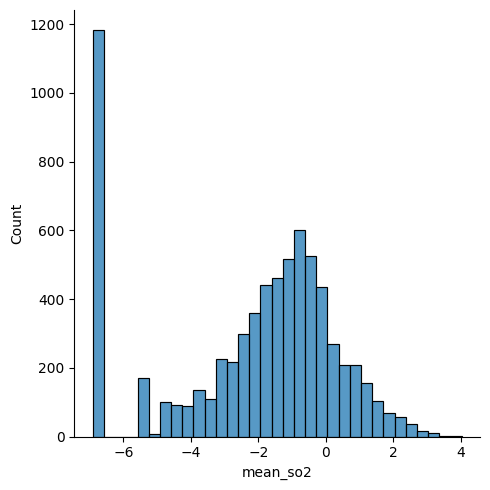

In [ ]:
sns.displot(np.log(nb_so2_records_agg[nb_so2_records_agg['day_time'] >= datetime.datetime.date(datetime.datetime.strptime('2022-01-01', "%Y-%m-%d"))]['mean_so2'] + 0.001))